# 프로젝트: CAM을 만들고 평가해 보자
|평가문항|상세기준|
|:---|:---|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


import cv2
import PIL
import copy
from PIL import Image

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


## ResNet모델

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


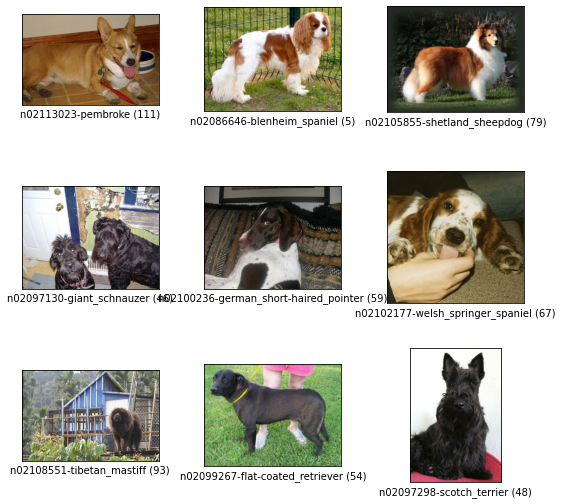

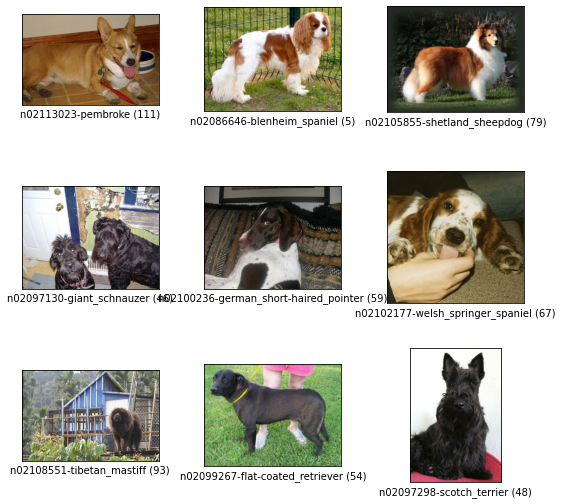

In [4]:
# 각 이미지의 클래스와 인덱스 확인
tfds.show_examples(ds_train, ds_info)

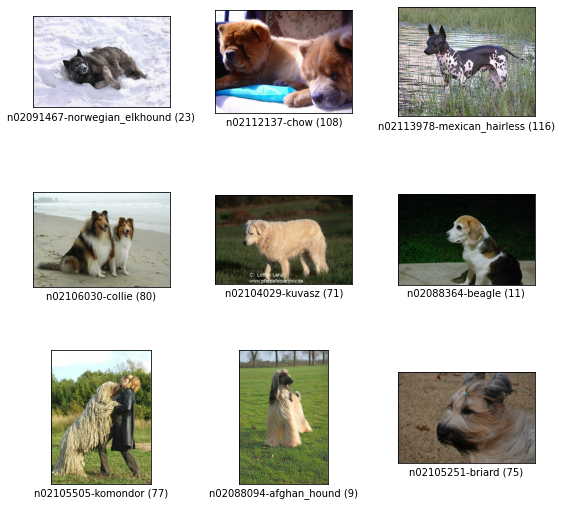

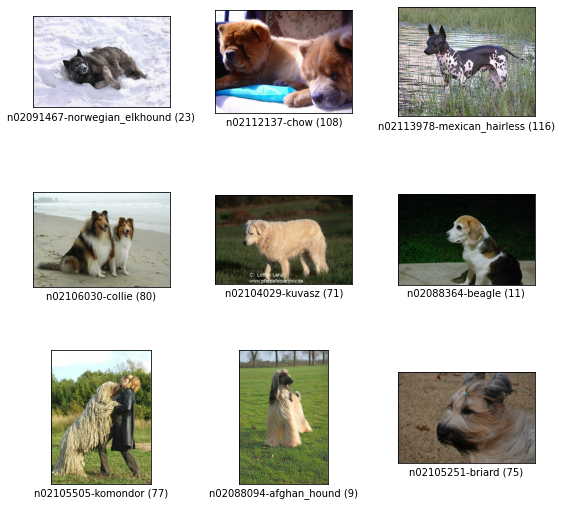

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
# feature 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [7]:
# 모델 만들기
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes,activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
# 모델 구조 확인
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

`conv5_block3_out`: feature map

In [9]:
# data normalization과 resize
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224]) # 정사각형 224,224로 통일
    input['image'] = tf.cast(image, tf.float32) / 255. # normalization
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
# 모델 컴파일 및 훈련
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 155s 197ms/step - loss: 2.2269 - accuracy: 0.4393 - val_loss: 3.3436 - val_accuracy: 0.2121
Epoch 2/10
750/750 [==============================] - 151s 201ms/step - loss: 0.6340 - accuracy: 0.8329 - val_loss: 1.3386 - val_accuracy: 0.6181
Epoch 3/10
750/750 [==============================] - 150s 200ms/step - loss: 0.1765 - accuracy: 0.9712 - val_loss: 1.0433 - val_accuracy: 0.6960
Epoch 4/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0597 - accuracy: 0.9966 - val_loss: 0.9587 - val_accuracy: 0.7240
Epoch 5/10
750/750 [==============================] - 151s 201ms/step - loss: 0.0303 - accuracy: 0.9983 - val_loss: 0.9846 - val_accuracy: 0.7238
Epoch 6/10
750/750 [==============================] - 151s 202ms/step - loss: 0.0202 - accuracy: 0.9992 - val_loss: 0.9578 - val_accuracy: 0.7313
Epoch 7/10
750/750 [==============================] - 151s 202ms/step - loss: 0.0155 - accuracy: 0.9997 - val_loss: 0.9703 -

In [12]:
#모델 경로
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_epoch10.h5'

In [13]:
#모델 저장하기
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
#모델 불러오기
#cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_epoch10.h5'
#cam_model = tf.keras.models.load_model(cam_model_path)

CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

100


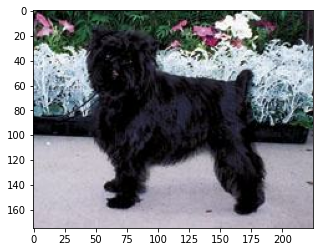

In [95]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [109]:
item

{'image': array([[[ 91, 101,  76],
         [160, 169, 148],
         [ 97, 105,  94],
         ...,
         [ 53,  40,  57],
         [ 53,  42,  56],
         [ 67,  57,  66]],
 
        [[139, 147, 124],
         [124, 131, 113],
         [ 47,  48,  42],
         ...,
         [ 49,  36,  53],
         [ 50,  39,  53],
         [ 63,  53,  62]],
 
        [[ 86,  90,  75],
         [ 46,  46,  36],
         [ 44,  34,  33],
         ...,
         [ 54,  42,  56],
         [ 54,  43,  57],
         [ 61,  51,  60]],
 
        ...,
 
        [[188, 180, 193],
         [193, 185, 198],
         [199, 191, 204],
         ...,
         [162, 154, 167],
         [167, 159, 172],
         [168, 160, 171]],
 
        [[191, 183, 196],
         [193, 185, 198],
         [196, 188, 201],
         ...,
         [162, 154, 167],
         [167, 159, 172],
         [169, 161, 172]],
 
        [[196, 188, 201],
         [195, 187, 200],
         [194, 186, 199],
         ...,
         [164, 156,

CAM을 생성하기 위해서는 3가지가 필요하다.
1. 특성 맵
2. 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
3. 원하는 클래스의 출력값이 필요합니다.

또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

## CAM 구현하기

In [99]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

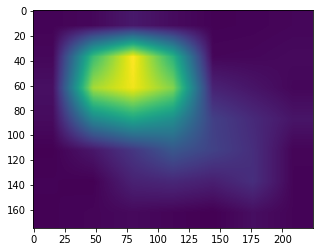

In [100]:
# 만든 함수로 CAM 이미지를 생성합시다.
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

`visualize_cam_on_image()` 함수: 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주기

In [101]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

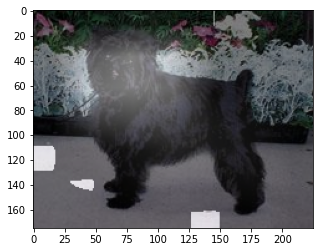

In [133]:
# visualize_cam_on_image() 함수 사용
type(item['image'])

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기

108


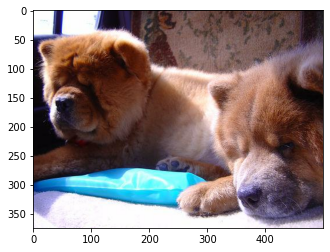

In [27]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 됩니다.

이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다.



아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.

In [28]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


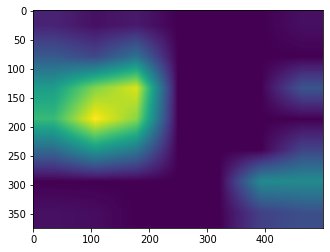

In [29]:
# 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

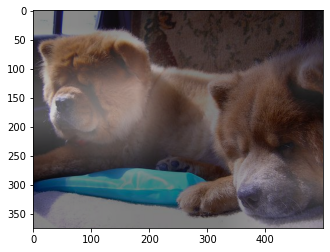

In [30]:
# visualize_cam_on_image() 함수 사용
type(item['image'])

origin_image_grad = item['image'].astype(np.uint8)
cam_image_3channel_grad = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image_grad = visualize_cam_on_image(cam_image_3channel_grad, origin_image_grad)
plt.imshow(blended_image_grad)

## 바운딩 박스 구하기

바운딩 박스를 시각화해 보세요.

bounding box는 minmax를 의미합니다. tfds의 경우 height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]를 의미하게 됩니다.
좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적입니다.

84


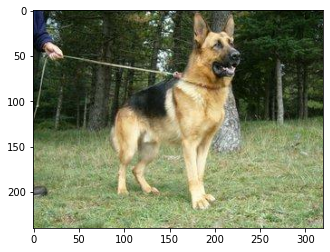

In [31]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

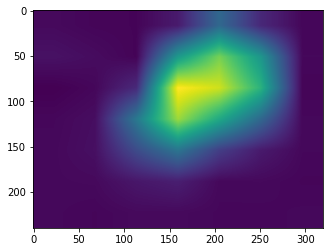

In [32]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [33]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [34]:
rect = get_bbox(cam_image)
rect

array([[ 72,   0],
       [292,   0],
       [292, 199],
       [ 72, 199]])

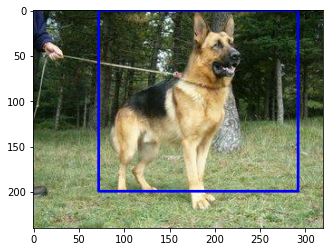

In [35]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [193]:
# get_bbox의 output을 minmax([ymin, xmin, ymax, xmax]) 형태로 바꾸는 함수
def get_minmax(item, rect):
    max_height = item['image'].shape[0] # y
    max_width = item['image'].shape[1] # x
    
    ymin = rect[0][1]/max_height
    xmin = rect[0][0]/max_width
    ymax = rect[2][1]/max_height
    xmax = rect[1][0]/max_width

    return [ymin, xmin, ymax, xmax]    

## IoU(Intersection Over Union) 구하기

정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.
![iou](https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-3.max-800x600.jpg)
IoU(Intersection over Union) 는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값입니다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됩니다.

In [84]:
def get_iou(gt_bbox, pred_bbox):
    # overlap 영역 계산
    x_i = max(gt_bbox[0], pred_bbox[0])
    y_i = max(gt_bbox[1], pred_bbox[1])
    x_f = min(gt_bbox[2], pred_bbox[2])
    y_f = min(gt_bbox[3], pred_bbox[3])

    overlap_area = max(0, x_f - x_i + 1) * max(0, y_f - y_i + 1)

    # 각 box의 area계산하기
    gt_bbox_area = (gt_bbox[2] - gt_bbox[0] + 1) * (gt_bbox[3] - gt_bbox[1] + 1)
    pred_bbox_area = (pred_bbox[2] - pred_bbox[0] + 1) * (pred_bbox[3] - pred_bbox[1] + 1)

    # Area of Union 계산하기
    union_area = gt_bbox_area + pred_bbox_area - overlap_area

    # IOU 계산
    iou = overlap_area / union_area
    return iou

CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [113]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [114]:
rect

array([[ 72,   0],
       [292,   0],
       [292, 199],
       [ 72, 199]])

In [93]:
gt_bbox = item['objects']['bbox'].tolist()[0] # ground bounding box
pred_bbox = get_minmax(item,rect) # prediction bounding box

# iou 계산
get_iou(gt_bbox, pred_bbox)

0.8493349328232548

## CAM vs. Grad-CAM 비교

In [194]:
def compare_results(img):
    print('the number of image: ', img['label'])
    
    plt.figure(figsize=(12,8))
    
    fig_x = 12
    fig_y = 8
    
    # original image
    plt.subplot(3,3,2)
    plt.imshow(img['image'])
    plt.title('Original Image')
    plt.axis('off')
    #plt.show()

    # CAM image
    plt.subplot(3,3,4)
    #plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.title('CAM Image')
    cam_image = generate_cam(cam_model, img)
    plt.imshow(cam_image)
    
    # Blended Image
    #plt.figure(figsize=(20,10))
    origin_image = img['image'].astype(np.uint8)
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
    blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
    plt.subplot(3,3,5)
    plt.axis('off')
    plt.title('Blended Image')
    plt.imshow(blended_image)
    
    # CAM Bounding box
    image = copy.deepcopy(img['image'])
    rect_cam = get_bbox(cam_image)
    image = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
    #plt.figure(figsize=(20,10))
    plt.subplot(3,3,6)
    plt.imshow(image)
    plt.axis('off')
    plt.title('CAM Bounding box')

    # gard-CAM image
    #plt.figure(figsize=(20,10))
    plt.subplot(3,3,7)
    plt.axis('off')
    plt.title('Grad CAM Image')
    grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', img)
    plt.imshow(grad_cam_image)
    
    # Blended Image_grad
    origin_image_grad = img['image'].astype(np.uint8)
    cam_image_3channel_grad = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
    blended_image_grad = visualize_cam_on_image(cam_image_3channel_grad, origin_image_grad)
    #plt.figure(figsize=(20,10))
    plt.subplot(3,3,8)
    plt.axis('off')
    plt.title('Blended Image_grad')
    plt.imshow(blended_image_grad)

    
    # grad-CAM Bounding box
    image = copy.deepcopy(img['image'])
    rect_gradcam = get_bbox(grad_cam_image)
    image = cv2.drawContours(image, [rect_gradcam], 0, (0,0,255), 2)
    #plt.figure(figsize=(20,10))
    plt.subplot(3,3,9)
    plt.imshow(image)
    plt.axis('off')
    plt.title('grad-CAM Bounding box')
    
    
    ##### 최종 도화지 출력!
    plt.show()
    
    # IOU 값
    gt_bbox = img['objects']['bbox'].tolist()[0] # ground bounding box
    
    pred_bbox_cam = get_minmax(img, rect_cam) # cam prediction bounding box
    pred_bbox_gradcam = get_minmax(img, rect_gradcam) # cam prediction bounding box

    iou_cam = get_iou(gt_bbox, pred_bbox_cam)
    iou_gradcam = get_iou(gt_bbox, pred_bbox_gradcam)
    
    print('CAM의 IOU: ', round(iou_cam,4))
    print('grad-CAM의 IOU: ', round(iou_gradcam,4))


the number of image:  100


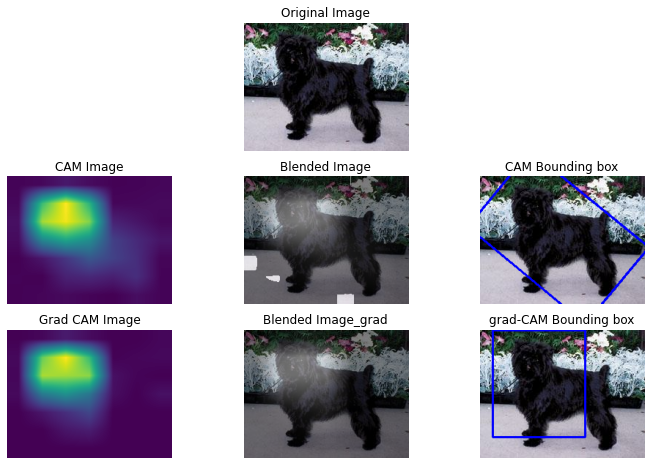

CAM의 IOU:  0.3871
grad-CAM의 IOU:  0.7565


In [195]:
img = get_one(ds_test)
compare_results(img)

the number of image:  75


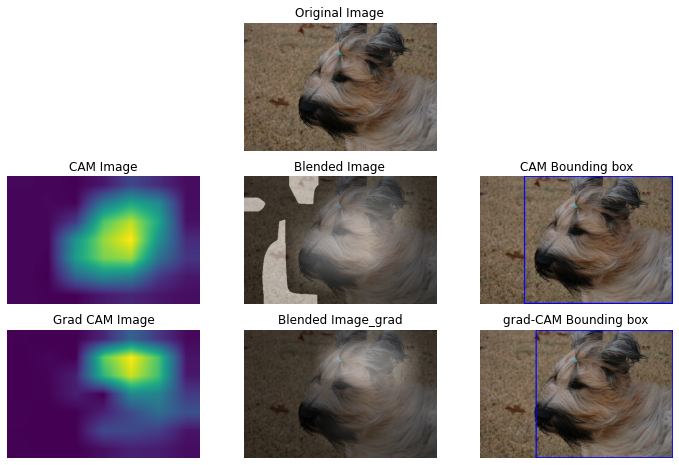

CAM의 IOU:  0.0017
grad-CAM의 IOU:  0.9942


In [196]:
img = get_one(ds_test)
compare_results(img)

the number of image:  67


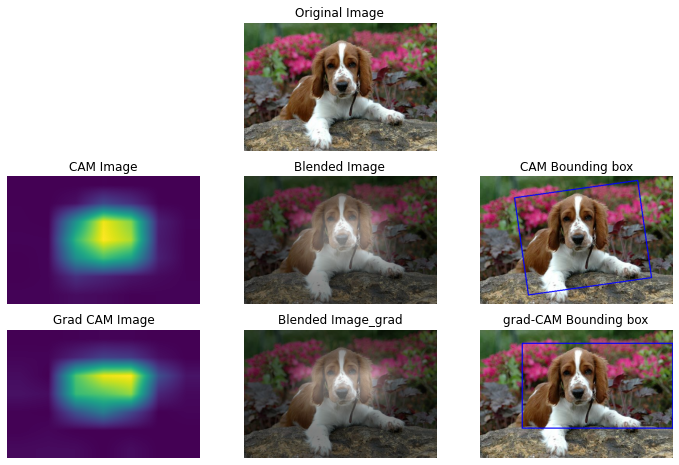

CAM의 IOU:  0.8545
grad-CAM의 IOU:  0.7592


In [197]:
img = get_one(ds_test)
compare_results(img)

the number of image:  11


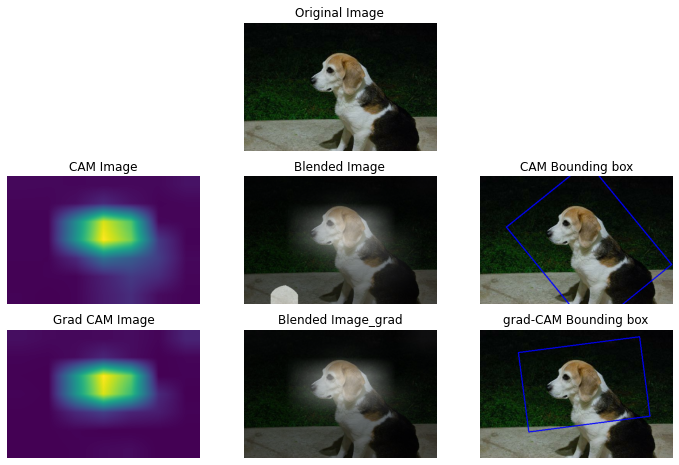

CAM의 IOU:  0.52
grad-CAM의 IOU:  0.7067


In [198]:
img = get_one(ds_test)
compare_results(img)

the number of image:  108


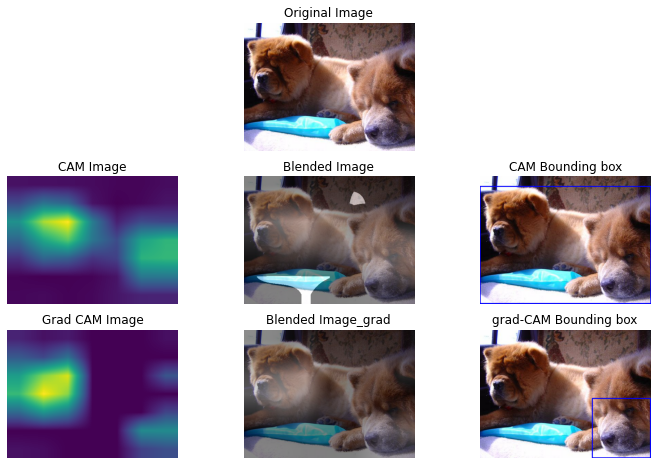

CAM의 IOU:  0.7242
grad-CAM의 IOU:  0.1935


In [200]:
img = get_one(ds_test)
compare_results(img)

# 회고
- CAM의 activation map과 달리 CAM의 Blended Image에서 흰색 부분이 섞여서 나온다.
- minmax와 rect의 좌표값 바꿔주는걸 신경썼다.
- original bounding box를 시각화해보려다 시간부족으로 안했다.